<a href="https://colab.research.google.com/github/conglapgit45/Object_Detection_ResNet/blob/main/Single_Object_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Classification only

# Download data

In [1]:
import kagglehub

# Download the latest dataset version
data_dir = kagglehub.dataset_download("andrewmvd/dog-and-cat-detection")
print("Path to dataset files:", data_dir )

100%|██████████| 1.03G/1.03G [00:07<00:00, 157MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/andrewmvd/dog-and-cat-detection/versions/1


# Import libraries

In [2]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

from PIL import Image
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from torchvision.models.resnet import ResNet18_Weights

# Define class dataset

In [5]:
# Dataset Class
class ImageDataset(Dataset):
    def __init__(self, annotations_dir, image_dir, transform=None):
        self.annotations_dir = annotations_dir
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = self.filter_images_with_multiple_objects()

    def filter_images_with_multiple_objects(self):
        valid_image_files = []
        for f in os.listdir(self.image_dir):
            if os.path.isfile(os.path.join(self.image_dir, f)):
                img_name = f
                annotation_name = os.path.splitext(img_name)[0] + ".xml"
                annotation_path = os.path.join(self.annotations_dir, annotation_name)
                # Keep images that have single object
                if self.count_objects_in_annotation(annotation_path) <= 1:
                    valid_image_files.append(img_name)
                else :
                    print(f"Image {img_name} has multiple objects and will beexcluded from the dataset")
        return valid_image_files

    def count_objects_in_annotation(self, annotation_path):
        try:
            tree = ET.parse(annotation_path)
            root = tree.getroot()
            count = 0
            for obj in root.findall("object"):
                count += 1
            return count
        except FileNotFoundError:
            return 0

    def __len__(self):
        return len(self.image_files)

    def __getitem__( self, idx):
        # Image path
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)

        # Load image
        image = Image.open(img_path).convert("RGB")

        # Annotation path
        annotation_name = os.path.splitext(img_name)[0] + ".xml"
        annotation_path = os.path.join(self.annotations_dir, annotation_name)

        # Parse annotation
        label = self.parse_annotation(annotation_path)

        if self.transform:
            image = self.transform(image)

        return image, label

    def parse_annotation(self, annotation_path):
        tree = ET.parse(annotation_path)
        root = tree.getroot()

        label = None
        for obj in root.findall("object"):
            name = obj.find("name").text
            if (label is None): # Take the first label for now. We are working with 1 label perimage
                label = name

        # Convert label to numerical representation (0 for cat, 1 for dog)
        label_num = 0 if label == "cat" else 1 if label == "dog" else -1

        return label_num

# Prepare data

In [7]:
# Data directory
annotations_dir = os.path.join(data_dir, 'annotations')
image_dir = os.path.join(data_dir, 'images')

# Get list of image files and create a dummy dataframe to split the data
image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]
df = pd.DataFrame({'image_name': image_files})

# Split data
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Datasets
train_dataset = ImageDataset(annotations_dir, image_dir, transform=transform)
val_dataset = ImageDataset(annotations_dir, image_dir, transform=transform)

# Filter datasets based on train_df and val_df
train_dataset.image_files = [f for f in train_dataset.image_files if f in train_df['image_name'].values]
val_dataset.image_files = [f for f in val_dataset.image_files if f in val_df['image_name'].values]

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

Image Cats_Test736.png has multiple objects and will beexcluded from the dataset
Image Cats_Test736.png has multiple objects and will beexcluded from the dataset


# Create Model

In [9]:
# Model
model = models.resnet18(weights = ResNet18_Weights.DEFAULT)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2) # 2 classes: cat and dog

# Device
device = torch.device("cuda" if torch.cuda.is_available () else "cpu")
print('Device:', device)
model.to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Show model summary
print(model)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 57.0MB/s]


Device: cuda
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inp

# Training loop

In [15]:
# Training Loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (data, targets) in enumerate(train_loader):
        data = data.to(device)
        targets = targets.to(device)

        scores = model(data)
        loss = criterion(scores, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Validation
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for data, targets in val_loader:
        data = data.to(device)
        targets = targets.to(device)
        scores = model(data)
        _, predictions = scores.max(1)
        correct += (predictions == targets).sum()
        total += targets.size(0)

        print(f'Epoch {epoch + 1}/{num_epochs}, Validation Accuracy: {float(correct)/float(total)*100:.2f}%')

Epoch 10/10, Validation Accuracy: 95.52%


Predicted label: 0
Actual label: 0


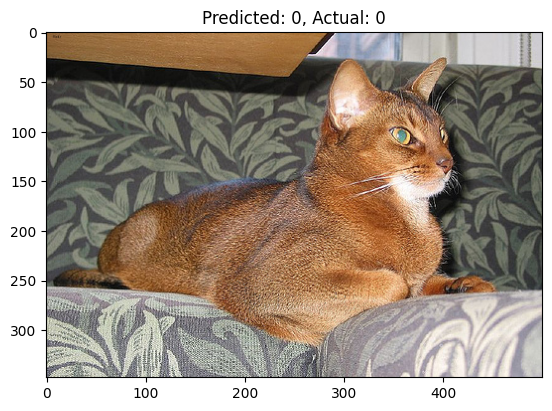

In [35]:
image_index = 18

image, label = val_dataset[image_index]
image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device

model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    output = model(image)
    _, predicted = torch.max(output, 1)

    print(f"Predicted label: {predicted.item()}")
    print(f"Actual label: {label}")


# Visualize the image
image_path = os.path.join(image_dir, val_dataset.image_files[image_index])
img = Image.open(image_path)
plt.imshow(img)
plt.title(f"Predicted: {predicted.item()}, Actual: {label}")
plt.show()

# 2. Classification + Bounding Box Regression

# Define class dataset with bounding box

In [39]:
# Dataset Class
class ImageDataset(Dataset):
    def __init__(self, annotations_dir, image_dir, transform=None):
        self.annotations_dir = annotations_dir
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = self.filter_images_with_multiple_objects()

    def filter_images_with_multiple_objects(self):
        valid_image_files = []
        for f in os.listdir(self.image_dir):
            if os.path.isfile(os.path.join(self.image_dir, f)):
                img_name = f
                annotation_name = os.path.splitext(img_name)[0] + ".xml"
                annotation_path = os.path.join(self.annotations_dir, annotation_name)
                if self.count_objects_in_annotation(annotation_path) == 1:
                    valid_image_files.append(img_name)
        return valid_image_files

    def count_objects_in_annotation(self, annotation_path):
        try :
            tree = ET.parse(annotation_path)
            root = tree.getroot()
            count = 0
            for obj in root.findall('object') :
                count += 1
            return count
        except FileNotFoundError:
            return 0

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Image path
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)

        # Load image
        image = Image.open(img_path).convert("RGB")

        # Annotation path
        annotation_name = os.path.splitext(img_name)[0] + ".xml"
        annotation_path = os.path.join(self.annotations_dir, annotation_name)

        # Parse annotation
        label, bbox = self.parse_annotation(annotation_path) # Get both label and bbox

        if self.transform:
            image = self.transform(image)

        return image, label, bbox

    def parse_annotation(self, annotation_path):
        tree = ET.parse(annotation_path)
        root = tree.getroot()
        # Get image size for normalization
        image_width = int(root.find('size/width').text)
        image_height = int(root.find('size/height').text)

        label = None
        bbox = None
        for obj in root.findall('object'):
            name = obj.find('name').text
            if label is None: # Take the first label
                label = name
                # Get bounding box coordinates
                xmin = int(obj.find('bndbox/xmin').text)
                ymin = int(obj.find('bndbox/ymin').text)
                xmax = int(obj.find('bndbox/xmax').text)
                ymax = int(obj.find('bndbox/ymax').text)

                # Normalize bbox coordinates to [0, 1]
                bbox = [
                    xmin / image_width,
                    ymin / image_height,
                    xmax / image_width,
                    ymax / image_height,
                ]

        # Convert label to numerical representation (0 for cat, 1 for dog)
        label_num = 0 if label == 'cat' else 1 if label == 'dog' else -1

        return label_num, torch.tensor(bbox, dtype=torch.float32)

# Prepare data

In [40]:
# Data directory
annotations_dir = os.path.join(data_dir, 'annotations')
image_dir = os.path.join(data_dir, 'images')

# Get list of image files and create a dummy dataframe to split the data
image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]
df = pd.DataFrame({'image_name': image_files})

# Split data
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Datasets
train_dataset = ImageDataset(annotations_dir, image_dir, transform=transform)
val_dataset = ImageDataset(annotations_dir, image_dir, transform=transform)

# Filter datasets based on train_df and val_df
train_dataset.image_files = [f for f in train_dataset.image_files if f in train_df['image_name'].values]
val_dataset.image_files = [f for f in val_dataset.image_files if f in val_df['image_name'].values]

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Create model with 2 heads

In [42]:
# Model with Two Heads
class TwoHeadedModel(nn.Module):
    def __init__(self, num_classes=2):
        super(TwoHeadedModel, self ).__init__()
        self.base_model = models.resnet18(weights = ResNet18_Weights.DEFAULT)
        self.num_ftrs = self.base_model.fc.in_features

        # Remove the original fully connected layer
        self.base_model.fc = nn.Identity()

        # Classification head
        self.classifier = nn.Linear(self.num_ftrs, num_classes)

        # Bounding box regression head
        self.regressor = nn.Linear(self.num_ftrs, 4)

    def forward(self, x):
        x = self.base_model(x)
        class_logits = self.classifier(x)
        bbox_coords = torch.sigmoid(self.regressor(x))
        return class_logits, bbox_coords

# Model
model = TwoHeadedModel()

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', device)
model.to(device)

# Loss and Optimizer
criterion_class = nn.CrossEntropyLoss()
criterion_bbox = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Device: cuda


# Training loop

In [46]:
# Training Loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (data, targets, bboxes) in enumerate(train_loader):
        data = data.to(device)
        targets = targets.to(device)
        bboxes = bboxes.to(device)

        scores, pred_bboxes = model(data)
        loss_class = criterion_class(scores, targets)
        loss_bbox = criterion_bbox(pred_bboxes, bboxes)
        loss = loss_class + loss_bbox # Combine losses

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Validation
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    total_loss_bbox = 0
    total_samples = 0
    for data, targets, bboxes in val_loader:
        data = data.to(device)
        targets = targets.to(device)
        bboxes = bboxes.to(device)

        scores, pred_bboxes = model(data)
        _, predictions = scores.max(1)
        correct += (predictions == targets).sum()
        total += targets.size(0)

        # Calculate bbox loss for monitoring (optional)
        total_loss_bbox += criterion_bbox(pred_bboxes, bboxes).item() * data.size(0)
        total_samples += data.size(0)

    avg_loss_bbox = total_loss_bbox / total_samples

    print(
        f'Epoch {epoch + 1}/{num_epochs}, Validation Accuracy: {float(correct)/float(total)*100:.2f}%, '
        f'Avg. Bbox Loss: {avg_loss_bbox:.4f}'
    )

Epoch 5/5, Validation Accuracy: 86.97%, Avg. Bbox Loss: 0.0117


Predicted label: 0
Actual label: 0
Predicted bounding box: [0.4791094  0.12511338 0.76507705 0.48488703]
Actual bounding box: [0.566      0.07471264 0.82       0.47988507]


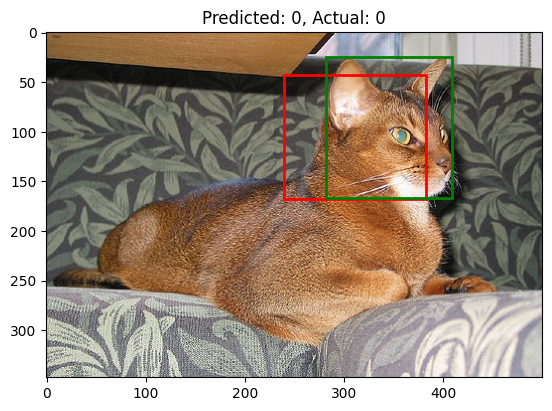

In [47]:
image_index = 18

image, label, bbox = val_dataset[image_index]
image = image.unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    output, predicted_bbox = model(image)
    _, predicted_label = torch.max(output, 1)

    print(f"Predicted label: {predicted_label.item()}")
    print(f"Actual label: {label}")
    print(f"Predicted bounding box: {predicted_bbox.cpu().numpy()[0]}")
    print(f"Actual bounding box: {bbox.numpy()}")

# Visualize the image and bounding box
image_path = os.path.join(image_dir, val_dataset.image_files[image_index])
img = Image.open(image_path)
plt.imshow(img)

# Draw the predicted bounding box
predicted_bbox_np = predicted_bbox.cpu().numpy()[0]
img_width, img_height = img.size
xmin = int(predicted_bbox_np[0] * img_width)
ymin = int(predicted_bbox_np[1] * img_height)
xmax = int(predicted_bbox_np[2] * img_width)
ymax = int(predicted_bbox_np[3] * img_height)

rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor='red', linewidth=2)
plt.gca().add_patch(rect)


# Draw the actual bounding box (optional)
bbox_np = bbox.numpy()
xmin_true = int(bbox_np[0] * img_width)
ymin_true = int(bbox_np[1] * img_height)
xmax_true = int(bbox_np[2] * img_width)
ymax_true = int(bbox_np[3] * img_height)

rect_true = plt.Rectangle((xmin_true, ymin_true), xmax_true - xmin_true, ymax_true - ymin_true, fill=False, edgecolor='green', linewidth=2)
plt.gca().add_patch(rect_true)


plt.title(f"Predicted: {predicted_label.item()}, Actual: {label}")
plt.show()